# ePSproc function verification & tests
19/06/20

For LF and AF calculations, trying to get to the bottom of issues with magnitudes and/or phases and/or formalism differences with raw ePS matrix elements.

## Set up

In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc or time
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc
import time

# Package fns.
# For module testing, include path to module here
import sys
import os
# modPath = r'D:\code\github\ePSproc'  # Win test machine
modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc, geomUtils

* plotly not found, plotly plots not available. 
* pyevtk not found, VTK export not available. 


## Clebsch Gordan coeffs

Numerical defn. from Moble's Spherical Functions, https://github.com/moble/spherical_functions/blob/master/spherical_functions/recursions/wigner3j.py

`def clebsch_gordan(j_1, m_1, j_2, m_2, j_3, m_3)`

`(-1.)**(j_1-j_2+m_3) * math.sqrt(2*j_3+1) * Wigner3j(j_1, j_2, j_3, m_1, m_2, -m_3)`

Initially try implementing this directly (based on modified 3j function outputs), then implement for ePS BLM calculations to match & check against published formalism.

In [2]:
# Set QNs up to Lmax (allowed M only)
Lmax = 1
QNs = geomUtils.genllL(Lmax = Lmax)

In [3]:
# Set CG function
def CG(QNs, dlist = ['l', 'lp', 'L', 'm', 'mp', 'M'], form = 'xarray'):
    """
    Basic CG from 3j calculation, from table of input QNs (corresponding to CG term defn.).
    
    QNs = [l, lp, L, m, mp, M]
    """
    
    # Set phase convention, CG(M3) > 3j(-M3)
    QNs[:,5] *= -1
    
    # Generate some 3j values (Xarray form) from supplied QNs
    w3j = geomCalc.w3jTable(QNs = QNs, dlist = dlist, form = form, nonzeroFlag = True)
    
    # Phase and degen terms
    # For testing set explicit version for full (l,lp,L) term, and photon (1,1,L) term
    if 'l' in dlist:
        CGphase = np.power(-1, np.abs(w3j.l - w3j.lp + w3j.M))
    else:
        CGphase = np.power(-1, np.abs(w3j.M))
        
    CGdegen = np.sqrt(2*w3j.L + 1)
    
    return CGphase * CGdegen * w3j

In [4]:
# Compute 3js
w3jX = geomCalc.w3jTable(QNs = QNs, form = 'xarray', nonzeroFlag = True)

# Compute CGs
CGX = CG(QNs)

/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Plotting data (No filename), pType=r, thres=0.01, with Seaborn
Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


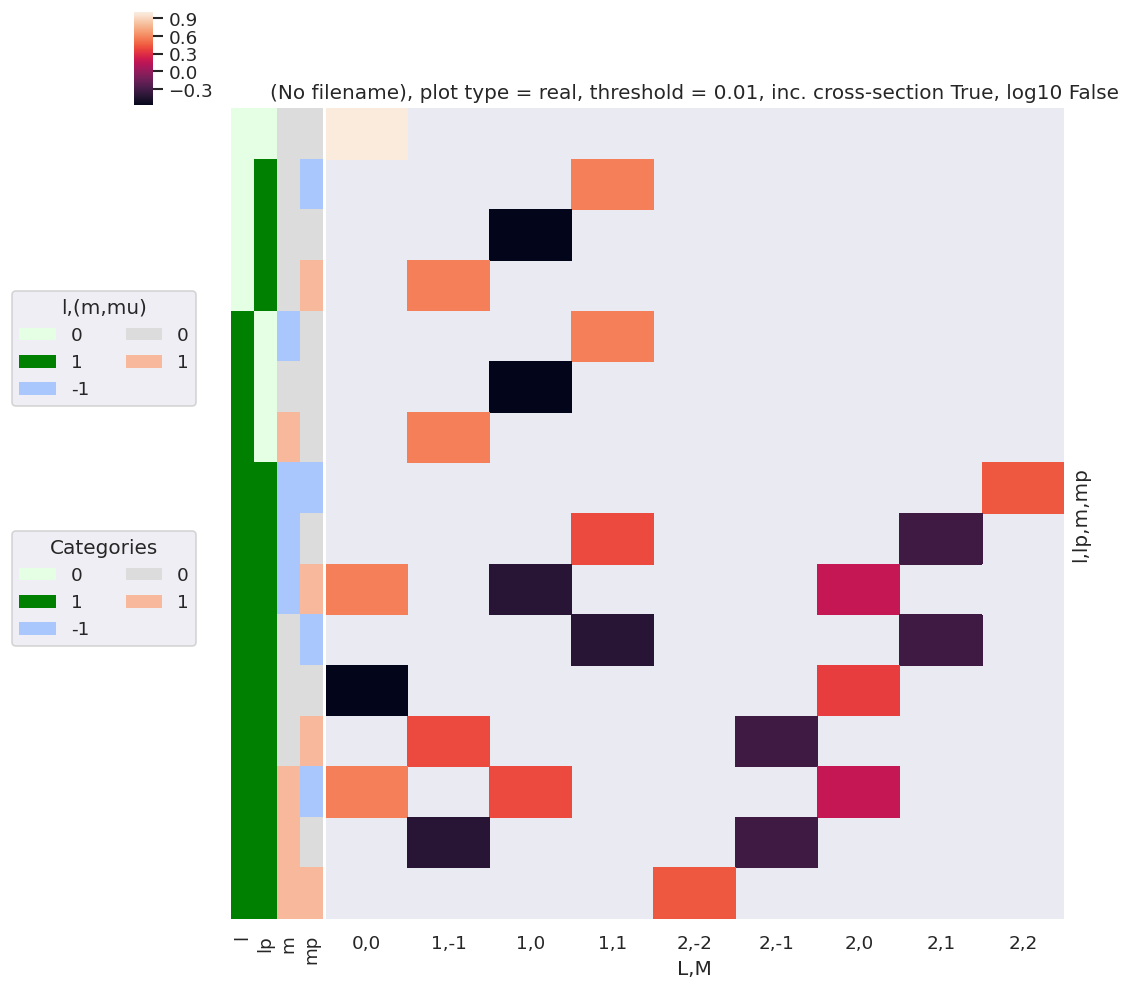

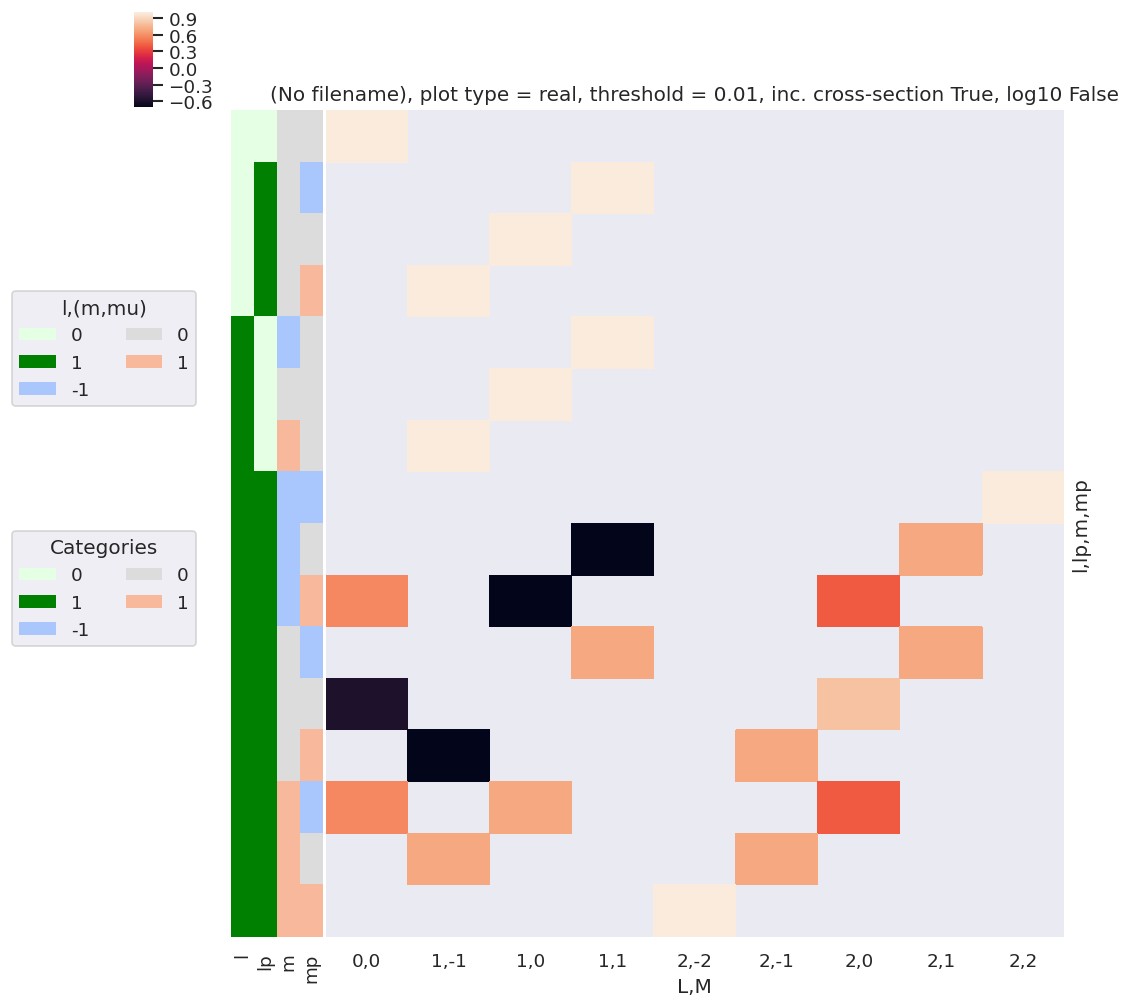

In [5]:
# Set parameters to restack the Xarray into (L,M) pairs
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(w3jX, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(CGX, xDim=xDim, pType = 'r')

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=None, with Seaborn
Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=None, with Seaborn


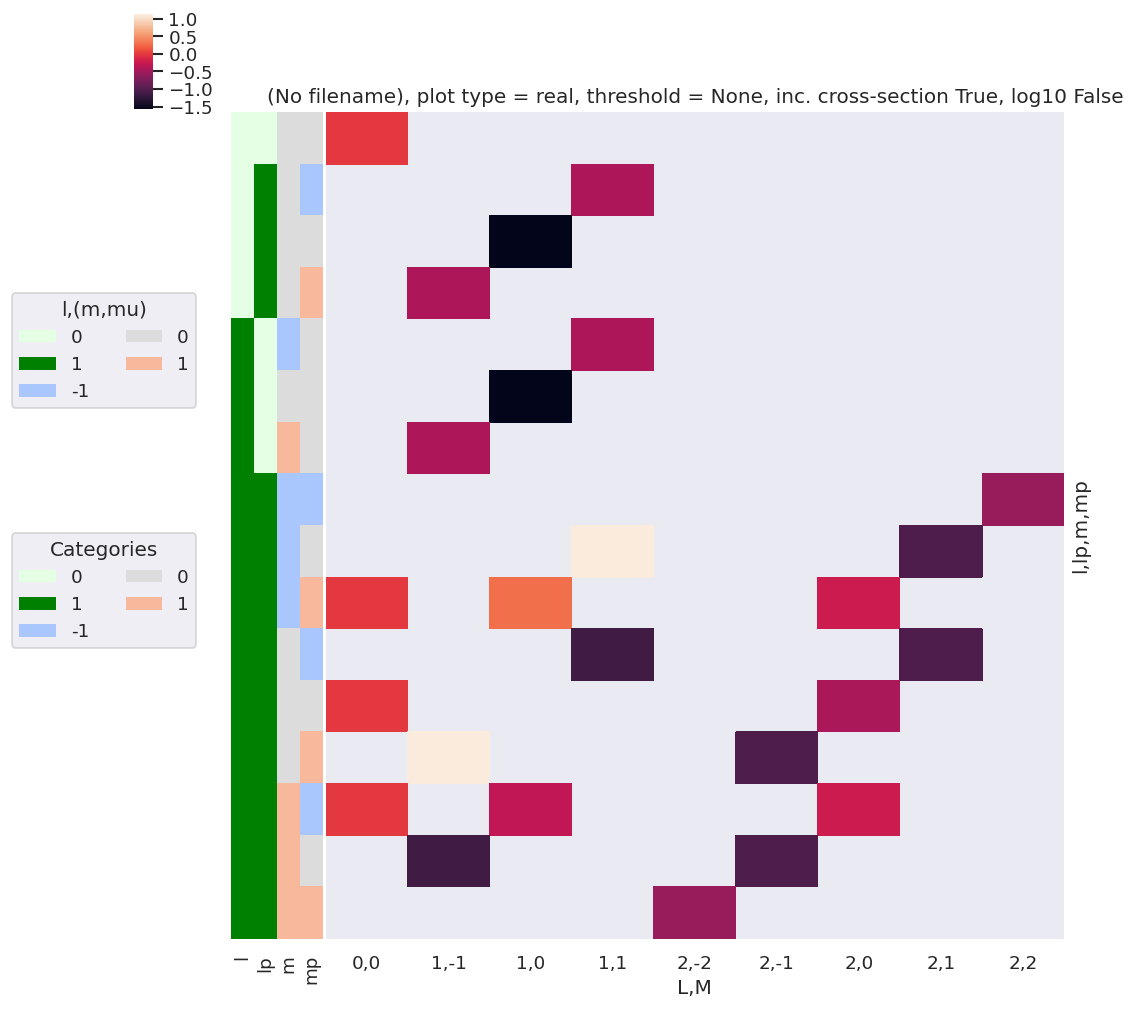

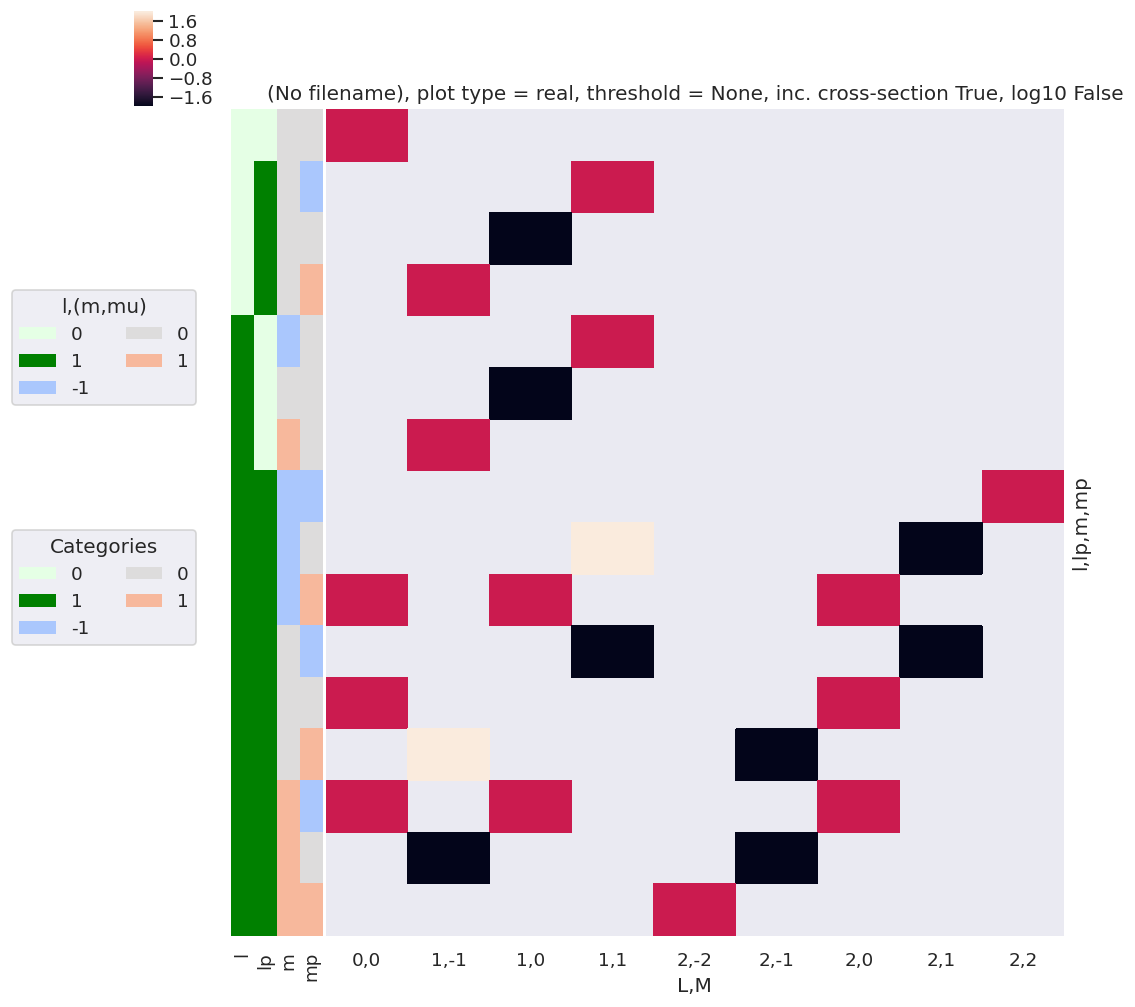

In [6]:
# Compare
daPlot, daPlotpd, legendList, gFig = ep.lmPlot((w3jX - CGX), xDim=xDim, pType = 'r', thres=None)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(np.sign(w3jX) - np.sign(CGX), xDim=xDim, pType = 'r', thres=None)

In [7]:
np.sign(w3jX)

<xarray.DataArray (QN: 25)>
array([ 1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,
       -1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1., -1., -1.,  1.])
Coordinates:
  * QN       (QN) MultiIndex
  - l        (QN) int64 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - lp       (QN) int64 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - L        (QN) int64 0 1 1 1 1 1 1 2 1 2 0 1 2 1 2 0 2 1 2 0 1 2 1 2 2
  - m        (QN) int64 0 0 0 0 -1 0 1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1
  - mp       (QN) int64 0 -1 0 1 0 0 0 -1 0 0 1 1 1 -1 -1 0 0 1 1 -1 -1 -1 0 0 1
  - M        (QN) int64 0 1 0 -1 1 0 -1 2 1 1 0 0 0 1 1 0 0 -1 -1 0 0 0 -1 -1 -2

In [8]:
np.sign(CGX)

<xarray.DataArray (QN: 25)>
array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
        1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])
Coordinates:
  * QN       (QN) MultiIndex
  - l        (QN) int64 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - lp       (QN) int64 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  - L        (QN) int64 0 1 1 1 1 1 1 2 1 2 0 1 2 1 2 0 2 1 2 0 1 2 1 2 2
  - m        (QN) int64 0 0 0 0 -1 0 1 -1 -1 -1 -1 -1 -1 0 0 0 0 0 0 1 1 1 1 1 1
  - mp       (QN) int64 0 -1 0 1 0 0 0 -1 0 0 1 1 1 -1 -1 0 0 1 1 -1 -1 -1 0 0 1
  - M        (QN) int64 0 1 0 -1 1 0 -1 2 1 1 0 0 0 1 1 0 0 -1 -1 0 0 0 -1 -1 -2

## Test N2 case

In [78]:
# Load data from modPath\data
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

# Scan data file
dataSet = ep.readMatEle(fileIn = dataFile)
dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.

*** ePSproc readMatEle(): scanning files for DumpIdy segments.

*** Scanning file(s)
['/home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  /home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 102 DumpIdy segments.
Found 102 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 102 sets of DumpIdy file segments, (0 blank)
*** ePSproc readMatEle(): scanning files for CrossSection segments.

*** Scanning file(s)
['/home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  /home/femtolab/github/ePSproc/data/photoionization/n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 3 CrossSection segments.
Found 3 CrossSection segments (sets of results).
Process

In [79]:
# Set parameters
SFflag = False
phaseConvention = 'S'
thres = 1e-1
selDims = {'it':1, 'Type':'L'}
thresDims = 'Eke'

# Set matrix elements
matE = dataSet[0].copy()

# Setting this here gives usual problem (non-matching XS values to getCro)
# Now testing multiplication at end of calc...
if SFflag:
    matE.values = matE * matE.SF

matEthres = ep.matEleSelector(matE, thres = thres, inds = selDims, dims = thresDims, sq = True, drop = True)


/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [40]:
# Calculate 3j sets

#*** For (l,lp) terms, use code from betaTerm(), but CG version
# Set QNs
QNs = geomUtils.genllpMatE(matEthres, phaseConvention = phaseConvention)
# Set phase convention for term (lp,l,-mp,m|2,-M) - NOTE also ordering of lp,l etc.!
dlistMatE = ['lp', 'l', 'L', 'mp', 'm', 'M']
# QNs[:,3] *= -1  # mp > -mp  # Including this restricts things to mp=0 only? Phase con choice? Doesn't seem correct!
                # Full calculation including this term sends PU continuum to zero/NaN.
QNs[:,5] *= -1  # M > -M

# Calculate main term + term with m=mp=M=0
CGmatE = CG(QNs=QNs, dlist = dlistMatE)
CGmatEM0 = CG(QNs = geomUtils.genllLList(QNs, uniqueFlag = True, mFlag = False), 
              dlist = dlistMatE, form='xdaLM')

# Multiply terms (as per betaTerm() code)
CGmatEmult = CGmatE.unstack()*CGmatEM0.drop('mSet').squeeze().unstack()


In [41]:
#*** For photon terms
# See EPR() and MFproj() for existing 3j prototypes.
dlistP = ['p1', 'p2', 'L', 'mup', 'mu', 'M']  # Note p1=p2=1 and will be dropped
QNsP=geomUtils.genllL(Lmin=1,Lmax=1)  # Generates all possible l1=l2=1 terms, no phase convention applied.

QNsP[:,3] *= -1  # mup > -mup
CGP = CG(QNs=QNsP, dlist = dlistP, form='xdaLM')
CGPM0 = CG(QNs = geomUtils.genllLList(QNsP, uniqueFlag = True, mFlag = False), 
              dlist = dlistP, form='xdaLM')

# Multiply terms (as per betaTerm() code)
CGPmult = CGP.unstack()*CGPM0.drop('mSet').squeeze().unstack()

In [113]:
CGP['M']

<xarray.DataArray 'M' (mSet: 9)>
array([ 2,  1,  0,  1,  0, -1,  0, -1, -2])
Coordinates:
  * mSet     (mSet) MultiIndex
  - mup      (mSet) int64 -1 -1 -1 0 0 0 1 1 1
  - mu       (mSet) int64 -1 0 1 -1 0 1 -1 0 1
  - M        (mSet) int64 2 1 0 1 0 -1 0 -1 -2

In [93]:
# Define matrix element multiplication term (code from mfblmGeom())
matEconj = matEthres.copy().conj()
# matEconj = matEconj.unstack().rename({'l':'lp','m':'mp','mu':'mup'})  # Full unstack
# matEmult = matEthres.unstack() * matEconj
matEconj = matEconj.unstack('LM').rename({'l':'lp','m':'mp','mu':'mup'})  # Unstack LM only.
matEmult = matEthres.unstack('LM') * matEconj
matEmult.attrs['dataType'] = 'multTest'

# Threshold product and drop dims.
# matEmult = ep.util.matEleSelector(matEmult, thres = thres, dims = thresDims)
matEmult = matEleSelector(matEmult, thres = thres, dims = thresDims)

/home/femtolab/anaconda3/envs/epsdev/lib/python3.7/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [43]:
# Multiply matE * photon terms
CGPM = CGmatEmult * CGPmult.squeeze(['p1','p2']).drop(['p1','p2'])

# Set phase = (-1)^(m'-mu)
CGPM *= np.power(-1, np.abs(CGPM.mp - CGPM.mu))

In [50]:
# Big mult
sumDims = ['mu', 'mup', 'l','lp','m','mp']
xDim = {'LM':['L','M']}

# Set any other terms...
degenllp = np.sqrt((2*matEmult.l+1)*(2*matEmult.lp+1))

Betas = (CGPM * matEmult * degenllp).sum(sumDims).stack(xDim)

# Renorm
# Apply SF here, or directly to matE?
# if SFflag:
#     normXS = np.abs(Betas.SF)
# #     normXS = np.abs(Betas.SF)**2
# else:
#     normXS = 1
normXS = 1

# normBLM = np.sqrt(4*np.pi/3) # 3/5  # Terms from 1999 SF6 paper
# normBLM = (4*np.pi**2)/5  # Term from 1985 long paper
normBLM = np.sqrt((2*Betas.L + 1)/(4*np.pi))  # Test conversion from Pl to Ylm normalisation
# normBLM = 1



BetasNorm = Betas.copy() * normXS

BetasNorm *= normBLM  # Apply overall factors *before* renorm

BetasNorm['XS'] = BetasNorm.sel({'L':0,'M':0}).drop('LM').copy()  # This basically works, and keeps all non-summed dims... but may give issues later...? Make sure to .copy(), otherwise it's just a pointer.
BetasNorm /= BetasNorm.sel({'L':0,'M':0}).drop('LM')

# BetasNorm *= normBLM


In [51]:
Betas.coords

Coordinates:
    Ehv      (Eke) float64 15.68 16.68 17.68 18.68 ... 62.68 63.68 64.68 65.68
  * Eke      (Eke) float64 0.1 1.1 2.1 3.1 4.1 5.1 ... 46.1 47.1 48.1 49.1 50.1
    it       int64 1
    Type     <U1 'L'
  * Sym      (Sym) MultiIndex
  - Cont     (Sym) object 'SU' 'PU'
  - Targ     (Sym) object 'SG' 'SG'
  - Total    (Sym) object 'SU' 'PU'
    SF       (Eke) complex128 (2.1560627+3.741674j) ... (4.4127053+1.8281945j)
  * LM       (LM) MultiIndex
  - L        (LM) int64 0 0 0 0 0 2 2 2 2 2
  - M        (LM) int64 -2 -1 0 1 2 -2 -1 0 1 2

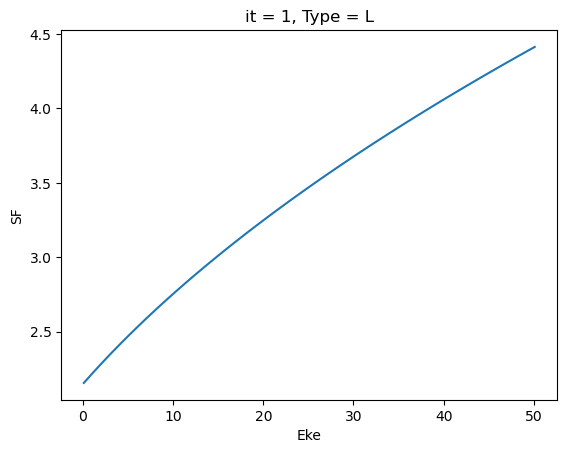

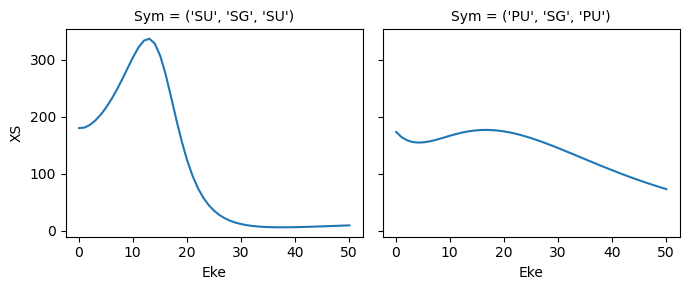

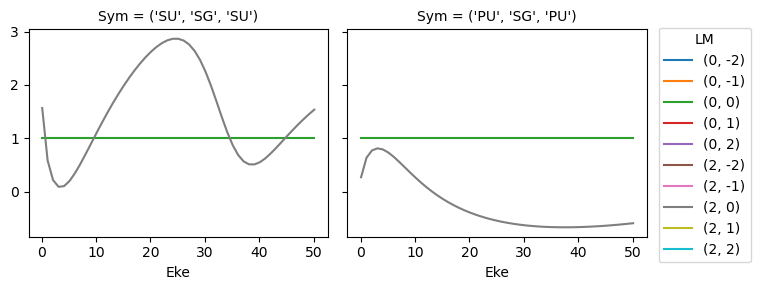

In [52]:
# Betas.squeeze().plot.line(x='Eke',col='Sym')
# BetasNorm.XS.real.plot.line(x='Eke', col='Sym');
BetasNorm.SF.real.plot()
ep.util.matEleSelector(BetasNorm.XS, thres = 0.001, dims='Eke', sq=False, drop=False).real.plot.line(x='Eke', col='Sym');
ep.util.matEleSelector(BetasNorm, thres = 0.1, dims='Eke', sq=False, drop=False).real.plot.line(x='Eke', col='Sym');


In [53]:
np.abs((matE*matE.SF).sel({'Eke':0.1}))

<xarray.DataArray (LM: 18, Sym: 2, mu: 3, it: 1, Type: 2)>
array([[[[[           nan,            nan]],

         [[           nan,            nan]],

         [[           nan,            nan]]],


        [[[           nan,            nan]],

         [[           nan,            nan]],

         [[3.51667897e+01, 3.84340154e+01]]]],



       [[[[           nan,            nan]],

         [[5.10581783e+01, 5.56343712e+01]],

         [[           nan,            nan]]],


        [[[           nan,            nan]],

         [[           nan,            nan]],

         [[           nan,            nan]]]],



       [[[[           nan,            nan]],

         [[           nan,            nan]],

         [[           nan,            nan]]],


        [[[3.51667897e+01, 3.84340154e+01]],

         [[           nan,            nan]],

         [[           nan,            nan]]]],



       [[[[           nan,            nan]],

         [[           nan,            nan]],

   

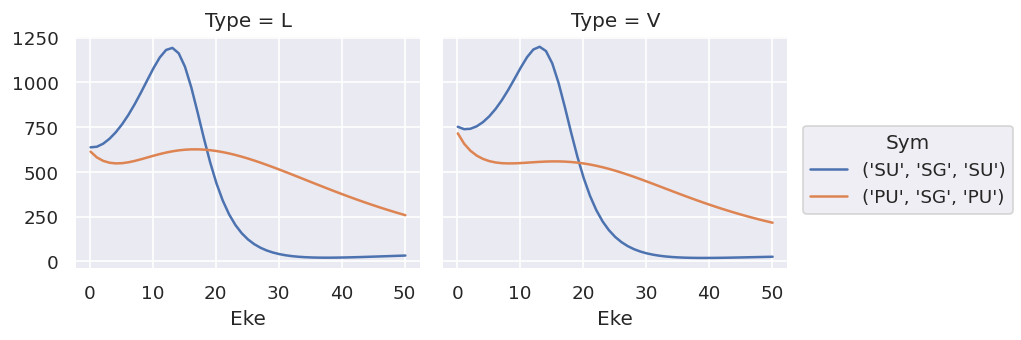

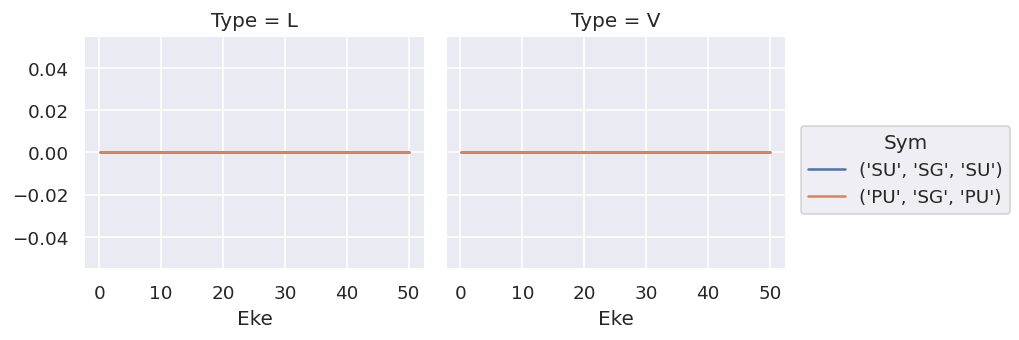

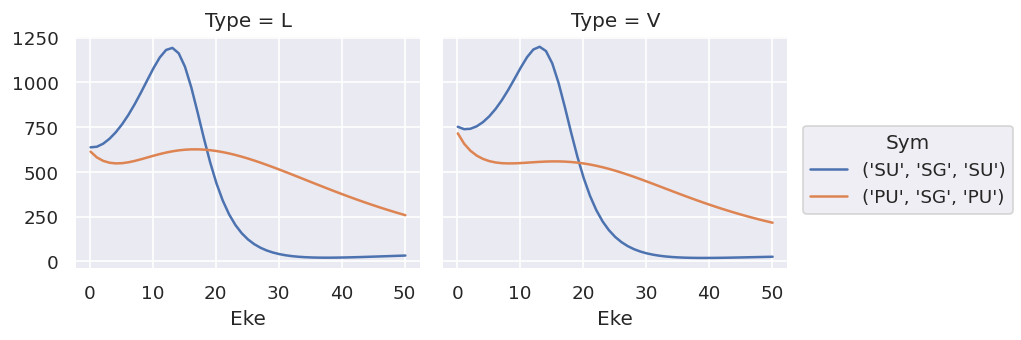

In [107]:
# Try alternative XS definition... looking at 1999 SF6 paper formalism
# XS = (matE.SF * (matE)**2).sum(['LM','mu','it'])  # This has real and imag parts
# XS = (matE.SF * (matE*matE.conj())).sum(['LM','mu','it'])  # This has real and imag parts, peaks at ~50 in SU channel.
# XS = ((matE.SF * matE) * (matE.SF * matE).conj()).sum(['LM','mu','it'])  # Re only, peaks at ~300 in SU channel.
# XS = (np.abs(matE.SF * matE)).sum(['LM','mu','it'])  # Re only, POOR SHAPE. peaks at ~24 in SU channel.
# XS = ((matE*matE.conj())).sum(['LM','mu','it'])  # Real only, peak ~18. Shape looks good.
# XS = (matE.SF * (np.abs(matE))).sum(['LM','mu','it']) # Poor shape
# XS = (matE.SF * (np.abs(matE)**2)).sum(['LM','mu','it']) # Pretty similar to previous attempts, peaks ~50

# Testing additional terms/normalisation
# XS = ((matE*matE.conj())).sum(['LM','mu','it'])/(4*np.pi)  # Real only, peak ~1.5. Shape looks good.
# XS = ((matE*matE.conj())).sum(['LM','mu','it'])/(4*np.pi)*((4*np.pi**2)/3)  # Real only, peak ~18. Shape looks good.
# XS = ((matE*matE.conj())).sum(['LM','mu','it'])*((4*np.pi**2)/3) # Re only, peaks ~ 240
# XS = ((matE.SF * matE) * (matE.SF * matE).conj()).sum(['LM','mu','it'])*((4*np.pi**2)/3)  # Re only, peaks at ~3500 in SU channel.
XS = ((matE.SF * matE) * (matE.SF * matE).conj()).sum(['LM','mu','it'])*((4*np.pi)/3)

#** XS = (matE.SF * np.abs(matE)).sum(['LM','mu','it'])  # UGH
# XS = (matE.SF * np.abs(matE**2)).sum(['LM','mu','it'])  # Re+Im, Peaks at ~50
# XS = (np.abs(matE.SF) * np.abs(matE**2)).sum(['LM','mu','it'])  # Re only, Peaks at ~70

# Investigating E/c term - so far assume this is included in SF... but maybe not? Not sure on units.
# XS = (matE.SF * (matE*matE.conj())).sum(['LM','mu','it']) * matE.Eke  # shape looks poor, peaks at ~500
# XS = ((matE*matE.conj())).sum(['LM','mu','it']) * matE.Eke  # shape looks poor, peaks at ~250

XS.real.plot.line(x='Eke',col='Type')
XS.imag.plot.line(x='Eke',col='Type')
XS.pipe(np.abs).plot.line(x='Eke',col='Type')
# XS

In [108]:
XS

<xarray.DataArray (Eke: 51, Sym: 2, Type: 2)>
array([[[ 637.26540177+0.j,  752.01798488+0.j],
        [ 613.10339356+0.j,  715.28927837+0.j]],

       [[ 640.49608363+0.j,  738.62925341+0.j],
        [ 580.87433174+0.j,  657.45830766+0.j]],

       [[ 657.44046936+0.j,  740.87015858+0.j],
        [ 561.58674762+0.j,  618.10947859+0.j]],

       [[ 684.81987538+0.j,  754.66172961+0.j],
        [ 551.18506809+0.j,  590.97630642+0.j]],

       [[ 721.14855914+0.j,  778.15653266+0.j],
        [ 547.35969886+0.j,  572.40776275+0.j]],

       [[ 765.74622358+0.j,  810.62089635+0.j],
        [ 548.54896347+0.j,  560.13599877+0.j]],

       [[ 818.15337127+0.j,  851.73139209+0.j],
        [ 553.49301026+0.j,  552.60037219+0.j]],

       [[ 877.71668223+0.j,  901.09490646+0.j],
        [ 561.07684581+0.j,  548.6202217 +0.j]],

       [[ 943.16238139+0.j,  957.7891209 +0.j],
        [ 570.29675752+0.j,  547.24506596+0.j]],

       [[1012.03460407+0.j, 1019.77824293+0.j],
        [ 580.26950026+0

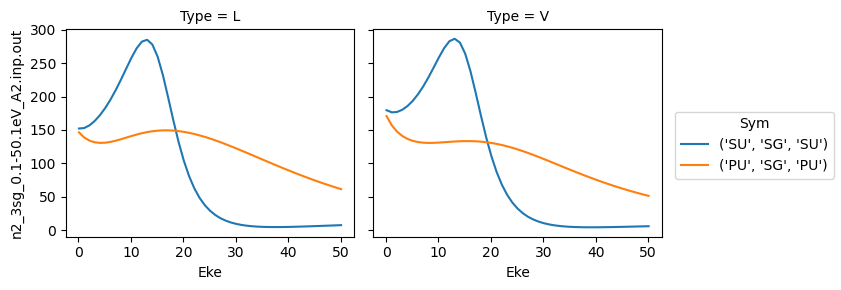

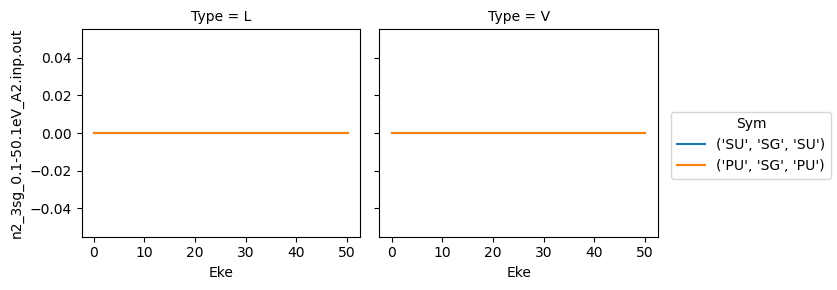

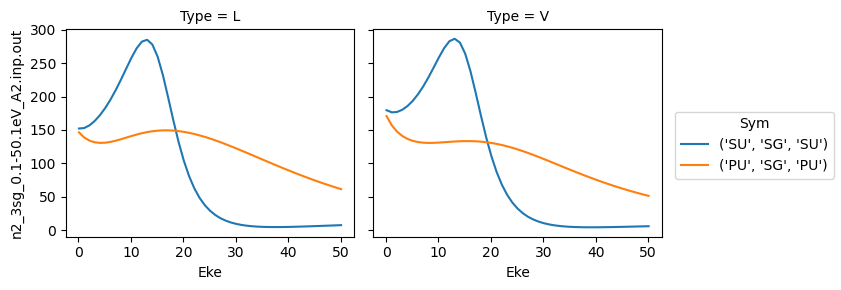

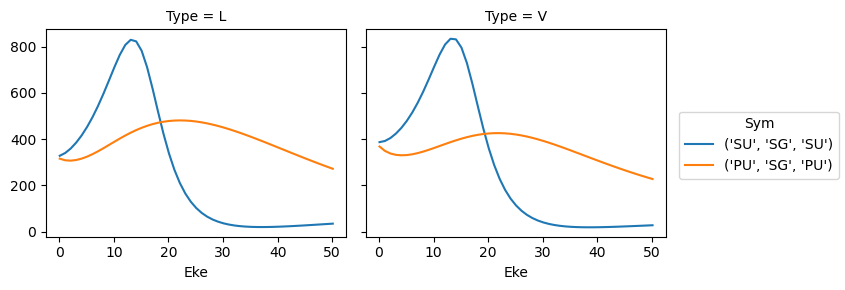

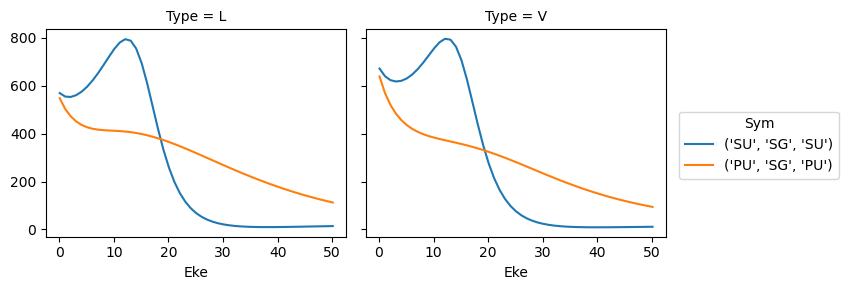

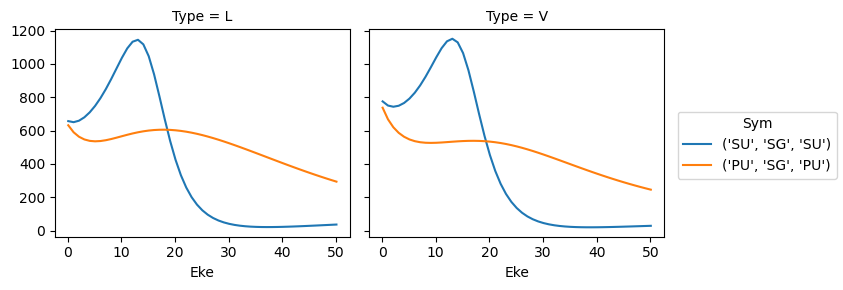

In [59]:
# Further XS testing. Note that Betas are NOT normalised by E-correct XS in 1999 paper formalism!!!

# Squared sum of matE
matEabsSum = (matE*matE.conj()).sum(['LM','mu','it'])

# Total XS
XS = matEabsSum * matE.SF

matEabsSum.real.plot.line(x='Eke',col='Type')
matEabsSum.imag.plot.line(x='Eke',col='Type')
matEabsSum.pipe(np.abs).plot.line(x='Eke',col='Type')

XS.real.plot.line(x='Eke',col='Type')
XS.imag.plot.line(x='Eke',col='Type')
XS.pipe(np.abs).plot.line(x='Eke',col='Type')

In [72]:
matE.sel({'Eke':0.1})

<xarray.DataArray 'n2_3sg_0.1-50.1eV_A2.inp.out' (LM: 18, Sym: 2, mu: 3, it: 1, Type: 2)>
array([[[[[            nan           +nanj,
                       nan           +nanj]],

         [[            nan           +nanj,
                       nan           +nanj]],

         [[            nan           +nanj,
                       nan           +nanj]]],


        [[[            nan           +nanj,
                       nan           +nanj]],

         [[            nan           +nanj,
                       nan           +nanj]],

         [[-6.20355581e+00-5.27556316e+00j,
           -6.78269929e+00-5.76241243e+00j]]]],



       [[[[            nan           +nanj,
                       nan           +nanj]],

         [[ 6.24652023e+00+1.00385594e+01j,
            6.80499827e+00+1.09391436e+01j]],

         [[            nan           +nanj,
                       nan           +nanj]]],


        [[[            nan           +nanj,
                       nan           +n

In [88]:
# testCplx = np.complex(-6.20355581e+00-5.27556316e+00j)
# testCplx = matE.sel({'Eke':0.1, 'l':1, 'm':0})
testCplx = (matE*matE.SF).sel({'Eke':0.1, 'l':1, 'm':0})
print(testCplx)
print(np.conj(testCplx)*testCplx)
print(np.conj(testCplx)*testCplx)

normFac = 4*(np.pi**2)/(3*3e8)
print(normFac)
print(np.conj(testCplx)*testCplx*normFac)

<xarray.DataArray (Sym: 2, mu: 3, it: 1, Type: 2)>
array([[[[       nan        +nanj,        nan        +nanj]],

        [[6.24652023+10.03855939j, 6.80499827+10.93914364j]],

        [[       nan        +nanj,        nan        +nanj]]],


       [[[       nan        +nanj,        nan        +nanj]],

        [[       nan        +nanj,        nan        +nanj]],

        [[       nan        +nanj,        nan        +nanj]]]])
Coordinates:
    Ehv      float64 15.68
    LM       object (1, 0)
    Eke      float64 0.1
  * it       (it) int64 1
  * Type     (Type) object 'L' 'V'
  * mu       (mu) int64 -1 0 1
  * Sym      (Sym) MultiIndex
  - Cont     (Sym) object 'SU' 'PU'
  - Targ     (Sym) object 'SG' 'SG'
  - Total    (Sym) object 'SU' 'PU'
    SF       complex128 (2.1560627+3.741674j)
<xarray.DataArray (Sym: 2, mu: 3, it: 1, Type: 2)>
array([[[[         nan+nanj,          nan+nanj]],

        [[139.79168965 +0.j, 165.97286504 +0.j]],

        [[         nan+nanj,          nan+nanj]

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn
Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


L                    0         2                                      
M                    0        -2       -1         0        1         2
mu mup p1 p2                                                          
-1 -1  1  1        NaN       NaN      NaN       NaN      NaN  0.816497
    0  1  1        NaN       NaN      NaN       NaN  0.57735       NaN
    1  1  1  -0.333333       NaN      NaN  0.333333      NaN       NaN
 0 -1  1  1        NaN       NaN      NaN       NaN  0.57735       NaN
    0  1  1   0.333333       NaN      NaN  0.666667      NaN       NaN
    1  1  1        NaN       NaN  0.57735       NaN      NaN       NaN
 1 -1  1  1  -0.333333       NaN      NaN  0.333333      NaN       NaN
    0  1  1        NaN       NaN  0.57735       NaN      NaN       NaN
    1  1  1        NaN  0.816497      NaN       NaN      NaN       NaN

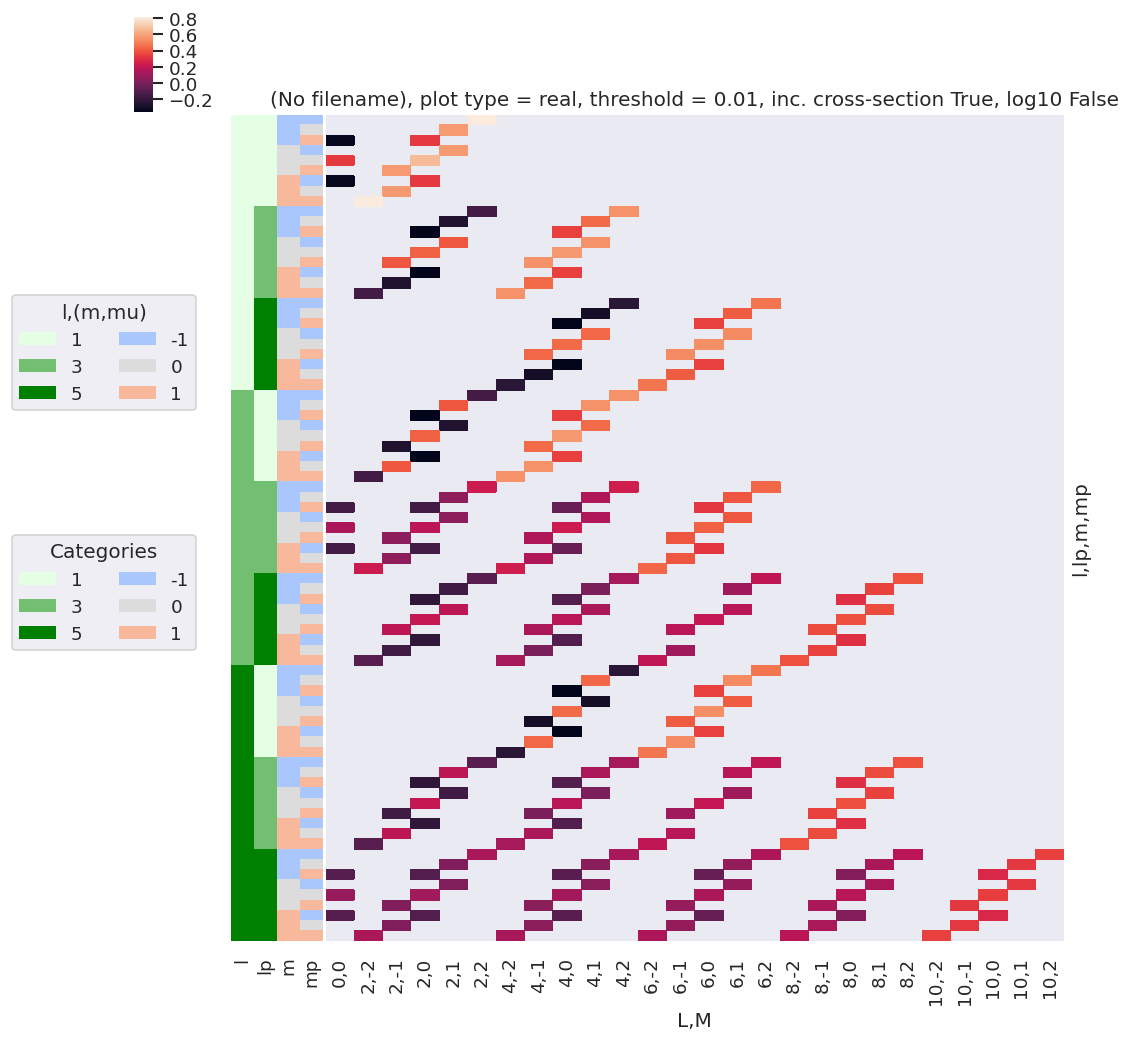

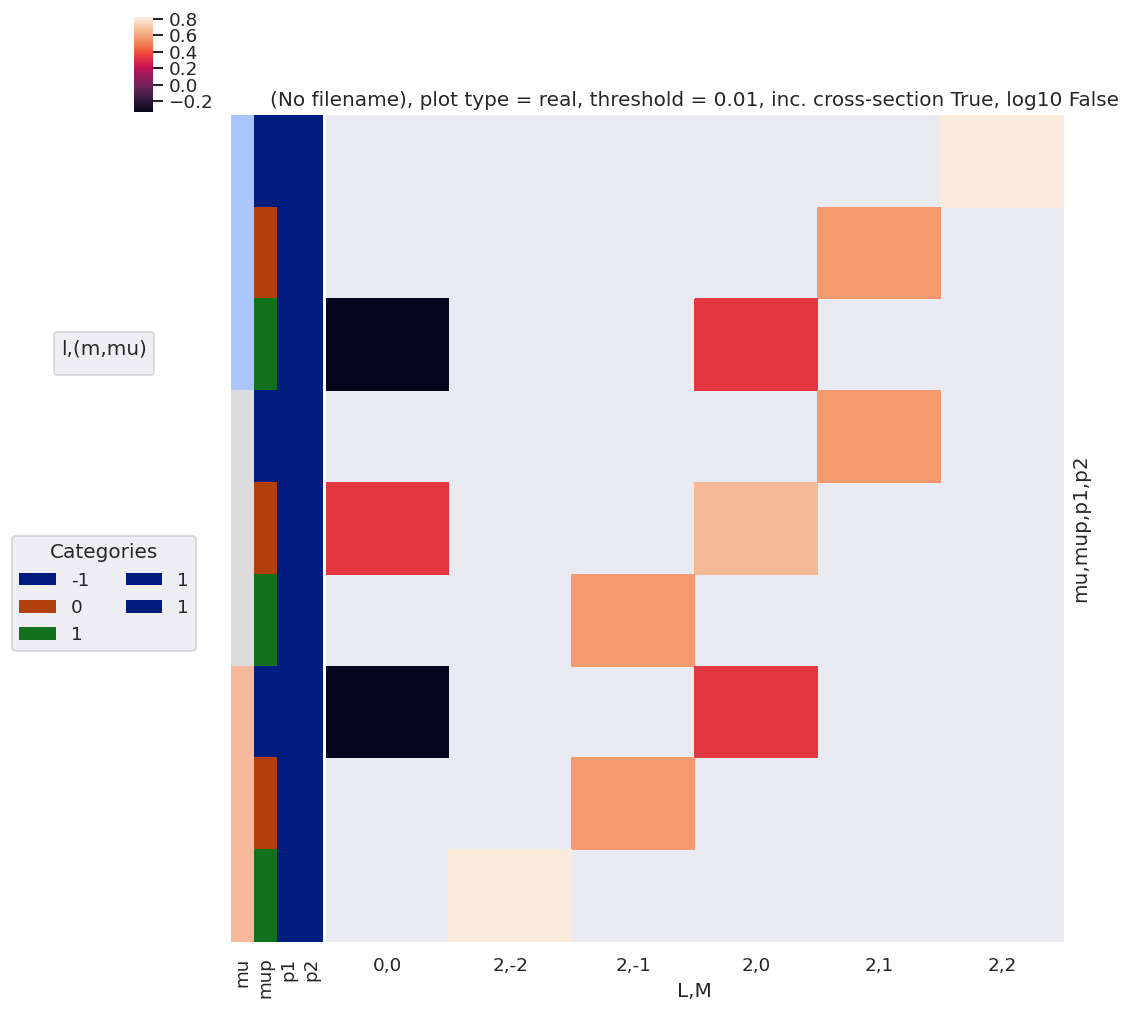

In [55]:
# Check terms
# Set parameters to restack the Xarray into (L,M) pairs
xDim = {'LM':['L','M']}

# Plot with ep.lmPlot(), real values
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(CGmatEmult, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(CGPmult, xDim=xDim, pType = 'r')
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(BetasNorm, xDim=xDim, pType = 'r')
daPlotpd